In [1]:
from GaborNet import GaborConv2d

2.0.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,BatchNormalization
import os
import seaborn as sns
from keras.initializers import glorot_uniform
from keras import backend as K

In [3]:
SIZE = 128

train_images = []
train_labels = []
for directory_path in glob.glob("dataset/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        train_images.append(img)
        train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

clay
loam
loamy sand
sand
sandy loam


In [4]:
test_images = []
test_labels = []
for directory_path in glob.glob("dataset/val/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.*")):
        #print(img_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (SIZE, SIZE))
        test_images.append(img)
        test_labels.append(fruit_label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [5]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [6]:
test_labels

array(['clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay',
       'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'clay', 'loam',
       'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam', 'loam',
       'loam', 'loam', 'loam', 'loam', 'loamy sand', 'loamy sand',
       'loamy sand', 'loamy sand', 'loamy sand', 'loamy sand',
       'loamy sand', 'loamy sand', 'loamy sand', 'loamy sand',
       'loamy sand', 'loamy sand', 'loamy sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand', 'sand',
       'sand', 'sand', '

In [7]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [8]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((244, 128, 128, 3), (244,), (119, 128, 128, 3), (119,))

In [9]:
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network.
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## GaborNet

In [10]:
def build_gabor_kernel(theta, Lambda, psi, sigma, gamma):
    """
    Build a Gabor kernel with the specified parameters.

    :param theta: Orientation of the Gabor filter.
    :param Lambda: Wavelength of the sinusoidal factor.
    :param psi: Phase offset of the sinusoidal factor.
    :param sigma: Standard deviation of the Gaussian envelope.
    :param gamma: Spatial aspect ratio.
    :return: Gabor kernel.
    """
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 3  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * math.cos(theta)), abs(nstds * sigma_y * math.sin(theta)))
    xmax = math.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * math.sin(theta)), abs(nstds * sigma_y * math.cos(theta)))
    ymax = math.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * math.cos(theta) + y * math.sin(theta)
    y_theta = -x * math.sin(theta) + y * math.cos(theta)

    # Gabor function
    gb = np.exp(-0.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(
        2 * np.pi / Lambda * x_theta + psi)

    # Rescale to [0, 1]
    gb -= np.min(gb)
    gb /= np.max(gb)

    # Reshape for Keras
    gb = np.reshape(gb, (ymax - ymin + 1, xmax - xmin + 1))
    gb = cv2.resize(gb, (3, 3))

    return gb

In [11]:
class GaborConv2D(Conv2D):
    """
    2D Gabor Convolutional layer.
    """

    def __init__(self, filters, kernel_size, strides=(1, 1), padding='same', data_format=None,
                 dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, theta=8, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1, **kwargs):


    #def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid', data_format=None,
     #            dilation_rate=(1, 1), activation='relu', use_bias=True, kernel_initializer='he_normal',
     #            bias_initializer='he_normal', kernel_regularizer='l2', bias_regularizer='l2', activity_regularizer='l2',
     #            kernel_constraint=None, bias_constraint=None, theta=8, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1, **kwargs):


        super(GaborConv2D, self).__init__(
            filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, data_format=data_format,
            dilation_rate=dilation_rate, activation=activation, use_bias=use_bias, kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint, bias_constraint=bias_constraint,
            **kwargs)

        self.theta = theta
        self.Lambda = Lambda
        self.psi = psi
        self.sigma = sigma
        self.gamma = gamma
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        """
        Build the Gabor kernel.

        :param input_shape: Shape of the input tensor.
        """
        input_dim = input_shape
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        input_dim = input_shape[channel_axis]
        #kernel_shape = self.kernel_size + (input_dim, self.filters)
        def build(self, input_shape):
            kernel_shape = self.kernel_size + (input_shape[-1], self.filters)

    # Create a trainable weight variable for this layer.
            self.kernel = self.add_weight(name='kernel',
                                  shape=kernel_shape,
                                  initializer='he_normal',
                                  #initializer= 'glorot_uniform'
                                  trainable=True)

            super(GaborConv2D, self).build(input_shape)


    def call(self, inputs):

        if self.data_format == 'channels_first':
            outputs = K.conv2d(inputs, self.kernel, strides=self.strides,
                               padding=self.padding, data_format=self.data_format,
                               dilation_rate=self.dilation_rate)
        else:
            kernel = K.permute_dimensions(self.kernel, (0, 1, 3, 2))
            outputs = K.conv2d(inputs, kernel, strides=self.strides,
                               padding=self.padding, data_format=self.data_format,
                               dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(outputs, self.bias, data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        return outputs
    # new layer added
    ''' def get_config(self):
        config = super(GaborConv2D, self).get_config()
        config.update({"units": self.units})
        return config'''

In [12]:
import numpy as np
from keras import backend as K
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import cv2
import math
import tensorflow as tf
import numpy as np


In [13]:
theta = 8.0
Lambda = np.pi/4
psi = 10.0
sigma = 0.5
gamma = 0.1

In [14]:
class GaborConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, theta, Lambda, psi, sigma, gamma, **kwargs):
        super(GaborConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.theta = theta
        self.Lambda = Lambda
        self.psi = psi
        self.sigma = sigma
        self.gamma = gamma

    def build(self, input_shape):


        kernel_shape = list(self.kernel_size) + [input_shape[-1], self.filters]
        #print('its running kernel shape ',kernel_shape)
        kernel = np.zeros(kernel_shape)
        for i in range(self.filters):
            kernel[:, :, :, i] = build_gabor_kernel(theta=self.theta, Lambda=self.Lambda, psi=self.psi,
                                                    sigma=self.sigma, gamma=self.gamma)
        self.kernel = tf.Variable(kernel, trainable=True, name='kernel')
        self.kernel = K.cast(self.kernel, dtype='float32')



    def call(self, inputs):
        outputs = tf.nn.conv2d(inputs, self.kernel, strides=(1, 1), padding="SAME")
        return outputs


    # new layer added get config only
    '''def get_config(self):
        config = super(GaborConv2D, self).get_config()
        config.update({"units": self.units})
        return config'''

In [15]:
from tensorflow.keras.layers import Input, Activation, MaxPooling2D, Flatten, Dense,Conv2D,BatchNormalization
from tensorflow.keras.models import Model
import keras

In [16]:

SIZE = 128
# Define input shape
input_shape = (SIZE, SIZE, 3)

# Define model architecture
inputs = Input(shape=input_shape)
x = GaborConv2D(filters=2, kernel_size=(3, 3), theta=8.0, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1)(inputs)

x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(2, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)


x = MaxPooling2D()(x)
x = Conv2D(4, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)


x = Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = MaxPooling2D()(x)

x = Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D()(x)

x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
# x = MaxPooling2D()(x)


x = Flatten()(x)

x = Dense(64, activation = 'relu',kernel_initializer='he_normal')(x)
out  = Dense(5, activation = 'softmax',kernel_initializer='he_normal')(x)

GCN_model = Model(inputs=inputs, outputs = out)

In [17]:
GCN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 gabor_conv2d (GaborConv2D)  (None, 128, 128, 2)       0         
                                                                 
 activation (Activation)     (None, 128, 128, 2)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 2)         0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 2)         18        
                                                                 
 batch_normalization (Batch  (None, 64, 64, 2)         8         
 Normalization)                                              

In [18]:
GCN_model.compile(loss='categorical_crossentropy', optimizer= keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [19]:
history2 = GCN_model.fit(x_train, y_train_one_hot,batch_size=8, epochs=30, validation_data = (x_test, y_test_one_hot))

Epoch 1/30
31/31 [==============================] - 4s 42ms/step - loss: 1.4557 - accuracy: 0.4057 - val_loss: 1.5840 - val_accuracy: 0.3866
Epoch 2/30
31/31 [==============================] - 1s 31ms/step - loss: 0.9483 - accuracy: 0.6598 - val_loss: 1.6475 - val_accuracy: 0.1092
Epoch 3/30
31/31 [==============================] - 1s 29ms/step - loss: 0.6517 - accuracy: 0.7705 - val_loss: 1.9284 - val_accuracy: 0.1261
Epoch 4/30
31/31 [==============================] - 1s 24ms/step - loss: 0.6611 - accuracy: 0.7992 - val_loss: 1.7406 - val_accuracy: 0.1429
Epoch 5/30
31/31 [==============================] - 1s 23ms/step - loss: 0.4354 - accuracy: 0.8648 - val_loss: 1.4943 - val_accuracy: 0.2689
Epoch 6/30
31/31 [==============================] - 1s 28ms/step - loss: 0.3392 - accuracy: 0.8893 - val_loss: 1.6757 - val_accuracy: 0.1345
Epoch 7/30
31/31 [==============================] - 1s 28ms/step - loss: 0.2749 - accuracy: 0.9098 - val_loss: 1.3385 - val_accuracy: 0.2773
Epoch 8/30
31

In [20]:
feature_extractor_gcn = Model(inputs=GCN_model.input, outputs=GCN_model.layers[-2].output)

# Use the feature extractor to get features from your data
features_train = feature_extractor_gcn.predict(x_train)
print(features_train.shape)

8/8 [==============================] - 0s 33ms/step
(244, 64)


In [21]:
features_test = feature_extractor_gcn.predict(x_test)
features_test.shape

4/4 [==============================] - 0s 32ms/step


(119, 64)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [23]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

rf_classifier.fit(features_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

In [24]:
prediction_RF = rf_classifier.predict(features_test)
prediction_RF = le.inverse_transform(prediction_RF)

print("Test Labels:", test_labels.shape)
print(test_labels)

print("Prediction", prediction_RF.shape)
print(prediction_RF)

Test Labels: (119,)
['clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay' 'clay'
 'clay' 'clay' 'clay' 'clay' 'clay' 'loam' 'loam' 'loam' 'loam' 'loam'
 'loam' 'loam' 'loam' 'loam' 'loam' 'loam' 'loam' 'loam' 'loamy sand'
 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand'
 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand' 'loamy sand'
 'loamy sand' 'loamy sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand' 'sand'
 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam'
 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam' 'sandy loam'
 'sandy l

In [25]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.9915966386554622


In [26]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, prediction_RF))

              precision    recall  f1-score   support

        clay       1.00      1.00      1.00        15
        loam       1.00      1.00      1.00        13
  loamy sand       1.00      0.92      0.96        13
        sand       0.99      1.00      0.99        66
  sandy loam       1.00      1.00      1.00        12

    accuracy                           0.99       119
   macro avg       1.00      0.98      0.99       119
weighted avg       0.99      0.99      0.99       119



<Axes: >

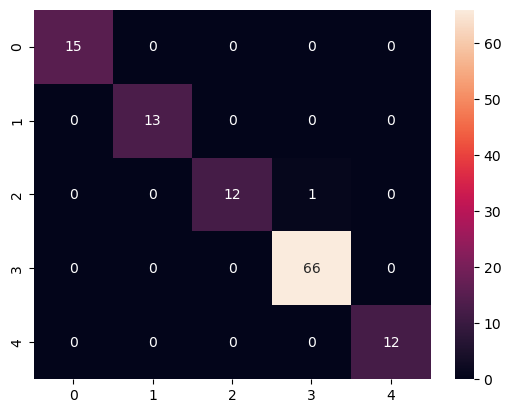

In [27]:
from sklearn.metrics import confusion_matrix

#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF)
sns.heatmap(cm, annot=True)

## BagNet

In [28]:
def getPatch(image, patch_h, patch_w, index_h, index_w):
    height = image.shape[1]
    width = image.shape[2]
    return image[:, (index_h*patch_h):((index_h+1)*patch_h), 
                 (index_w*patch_w):((index_w+1)*patch_w), :]

In [29]:
keras.models.Sequential()

In [30]:
def cnnBlock(input):
    from keras import layers

    x = GaborConv2D(filters=2, kernel_size=(3, 3), theta=8.0, Lambda=np.pi/4, psi=10.0, sigma=0.5, gamma=0.1)(input)

    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(2, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)


    x = MaxPooling2D()(x)
    x = Conv2D(4, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)


    x = Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    return x

In [31]:
# BAGNET BLOCK
def bagnetBlock(input, patchHeight, patchWidth, h, w):
    import keras
    from keras import layers
    
    patch = getPatch(input, patchHeight, patchWidth, h, w)
    cnn = cnnBlock(patch)
    flat = layers.Flatten()(cnn)
    dense = layers.Dense(5, activation='softmax')(flat)
    return dense

In [32]:
# BUILDS MODEL
def buildModel(imgHeight, imgWidth, patchHeight, patchWidth):
    import keras
    from keras import initializers
    from keras import layers
    from keras import models

    if( imgHeight % patchHeight != 0 ):
        print('Wrong ratio between image height and patch height!')
        return None
    if( imgWidth % patchWidth != 0 ):
        print('Wrong ratio between image width and patch width!')
        return None

    nRows = int(imgHeight / patchHeight)
    nCols = int(imgWidth / patchWidth)

    input = layers.Input(shape=(imgHeight, imgWidth, 3))
    heatmaps = []
    for h in range(nRows):
        for w in range(nCols):
            heatmaps.append( bagnetBlock(input, patchHeight, patchWidth, h, w) )

    classAvgs = layers.Average()(heatmaps)
    softmax = keras.activations.softmax(classAvgs, axis=-1)

    model = models.Model( inputs=input, outputs=softmax )

    return model

In [33]:
# Images size
IM_HEIGHT = 128
IM_WIDTH = 128
PATCH_HEIGHT = 16
PATCH_WIDTH = 16

BATCH_SIZE = 128

In [36]:
    # Builds Model
# model = buildModel(IM_HEIGHT, IM_WIDTH, PATCH_HEIGHT, PATCH_WIDTH)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 16, 16, 3)            0         ['input_2[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                            

 tf.__operators__.getitem_2  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 6 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_2  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 7 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_2  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 8 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_2  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 9 (Slicin

                                                                                                  
 tf.__operators__.getitem_5  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 4 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_5  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 5 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_5  (None, 16, 16, 3)            0         ['input_2[0][0]']             
 6 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__oper

 2D)                                                                0][0]']                       
                                                                                                  
 gabor_conv2d_19 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_18[
 2D)                                                                0][0]']                       
                                                                                                  
 gabor_conv2d_20 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_19[
 2D)                                                                0][0]']                       
                                                                                                  
 gabor_conv2d_21 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_20[
 2D)                                                                0][0]']                       
          

 gabor_conv2d_46 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_45[
 2D)                                                                0][0]']                       
                                                                                                  
 gabor_conv2d_47 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_46[
 2D)                                                                0][0]']                       
                                                                                                  
 gabor_conv2d_48 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_47[
 2D)                                                                0][0]']                       
                                                                                                  
 gabor_conv2d_49 (GaborConv  (None, 16, 16, 2)            0         ['tf.__operators__.getitem_48[
 2D)      

 activation_14 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_14[0][0]']     
                                                                                                  
 activation_15 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_15[0][0]']     
                                                                                                  
 activation_16 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_16[0][0]']     
                                                                                                  
 activation_17 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_17[0][0]']     
                                                                                                  
 activation_18 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_18[0][0]']     
                                                                                                  
 activatio

                                                                                                  
 activation_56 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_56[0][0]']     
                                                                                                  
 activation_57 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_57[0][0]']     
                                                                                                  
 activation_58 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_58[0][0]']     
                                                                                                  
 activation_59 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_59[0][0]']     
                                                                                                  
 activation_60 (Activation)  (None, 16, 16, 2)            0         ['gabor_conv2d_60[0][0]']     
          

 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_70 (MaxPooli  (None, 8, 8, 2)              0         ['activation_23[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_73 (MaxPooli  (None, 8, 8, 2)              0         ['activation_24[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_76 (MaxPooli  (None, 8, 8, 2)              0         ['activation_25[0][0]']       
 ng2D)                                                                                            
          

 max_pooling2d_151 (MaxPool  (None, 8, 8, 2)              0         ['activation_50[0][0]']       
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_154 (MaxPool  (None, 8, 8, 2)              0         ['activation_51[0][0]']       
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_157 (MaxPool  (None, 8, 8, 2)              0         ['activation_52[0][0]']       
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_160 (MaxPool  (None, 8, 8, 2)              0         ['activation_53[0][0]']       
 ing2D)   

 conv2d_140 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_61[0][0]']    
                                                                                                  
 conv2d_147 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_64[0][0]']    
                                                                                                  
 conv2d_154 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_67[0][0]']    
                                                                                                  
 conv2d_161 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_70[0][0]']    
                                                                                                  
 conv2d_168 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_73[0][0]']    
                                                                                                  
 conv2d_17

                                                                                                  
 conv2d_434 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_187[0][0]']   
                                                                                                  
 conv2d_441 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_190[0][0]']   
                                                                                                  
 conv2d_448 (Conv2D)         (None, 8, 8, 2)              18        ['max_pooling2d_193[0][0]']   
                                                                                                  
 batch_normalization_6 (Bat  (None, 8, 8, 2)              8         ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_nor

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_162 (B  (None, 8, 8, 2)              8         ['conv2d_189[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_168 (B  (None, 8, 8, 2)              8         ['conv2d_196[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_174 (B  (None, 8, 8, 2)              8         ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
          

 batch_normalization_324 (B  (None, 8, 8, 2)              8         ['conv2d_378[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_330 (B  (None, 8, 8, 2)              8         ['conv2d_385[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_336 (B  (None, 8, 8, 2)              8         ['conv2d_392[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_342 (B  (None, 8, 8, 2)              8         ['conv2d_399[0][0]']          
 atchNorma

                                                                                                  
 max_pooling2d_56 (MaxPooli  (None, 4, 4, 2)              0         ['batch_normalization_108[0][0
 ng2D)                                                              ]']                           
                                                                                                  
 max_pooling2d_59 (MaxPooli  (None, 4, 4, 2)              0         ['batch_normalization_114[0][0
 ng2D)                                                              ]']                           
                                                                                                  
 max_pooling2d_62 (MaxPooli  (None, 4, 4, 2)              0         ['batch_normalization_120[0][0
 ng2D)                                                              ]']                           
                                                                                                  
 max_pooli

 ing2D)                                                             ]']                           
                                                                                                  
 max_pooling2d_140 (MaxPool  (None, 4, 4, 2)              0         ['batch_normalization_276[0][0
 ing2D)                                                             ]']                           
                                                                                                  
 max_pooling2d_143 (MaxPool  (None, 4, 4, 2)              0         ['batch_normalization_282[0][0
 ing2D)                                                             ]']                           
                                                                                                  
 max_pooling2d_146 (MaxPool  (None, 4, 4, 2)              0         ['batch_normalization_288[0][0
 ing2D)                                                             ]']                           
          

 conv2d_92 (Conv2D)          (None, 4, 4, 4)              36        ['max_pooling2d_41[0][0]']    
                                                                                                  
 conv2d_99 (Conv2D)          (None, 4, 4, 4)              36        ['max_pooling2d_44[0][0]']    
                                                                                                  
 conv2d_106 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_47[0][0]']    
                                                                                                  
 conv2d_113 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_50[0][0]']    
                                                                                                  
 conv2d_120 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_53[0][0]']    
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_386 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_167[0][0]']   
                                                                                                  
 conv2d_393 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_170[0][0]']   
                                                                                                  
 conv2d_400 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_173[0][0]']   
                                                                                                  
 conv2d_407 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_176[0][0]']   
                                                                                                  
 conv2d_414 (Conv2D)         (None, 4, 4, 4)              36        ['max_pooling2d_179[0][0]']   
          

                                                                                                  
 batch_normalization_133 (B  (None, 4, 4, 4)              16        ['conv2d_155[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_139 (B  (None, 4, 4, 4)              16        ['conv2d_162[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_145 (B  (None, 4, 4, 4)              16        ['conv2d_169[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_301 (B  (None, 4, 4, 4)              16        ['conv2d_351[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_307 (B  (None, 4, 4, 4)              16        ['conv2d_358[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_313 (B  (None, 4, 4, 4)              16        ['conv2d_365[0][0]']          
 atchNormalization)                                                                               
          

 conv2d_93 (Conv2D)          (None, 4, 4, 8)              136       ['batch_normalization_79[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_100 (Conv2D)         (None, 4, 4, 8)              136       ['batch_normalization_85[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_107 (Conv2D)         (None, 4, 4, 8)              136       ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 4, 4, 8)              136       ['batch_normalization_97[0][0]
          

                                                                                                  
 conv2d_289 (Conv2D)         (None, 4, 4, 8)              136       ['batch_normalization_247[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_296 (Conv2D)         (None, 4, 4, 8)              136       ['batch_normalization_253[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_303 (Conv2D)         (None, 4, 4, 8)              136       ['batch_normalization_259[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_31

 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_32 (Ba  (None, 4, 4, 8)              32        ['conv2d_37[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_38 (Ba  (None, 4, 4, 8)              32        ['conv2d_44[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_44 (Ba  (None, 4, 4, 8)              32        ['conv2d_51[0][0]']           
 tchNormalization)                                                                                
          

 batch_normalization_194 (B  (None, 4, 4, 8)              32        ['conv2d_226[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_200 (B  (None, 4, 4, 8)              32        ['conv2d_233[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_206 (B  (None, 4, 4, 8)              32        ['conv2d_240[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_212 (B  (None, 4, 4, 8)              32        ['conv2d_247[0][0]']          
 atchNorma

                                                                                                  
 batch_normalization_362 (B  (None, 4, 4, 8)              32        ['conv2d_422[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_368 (B  (None, 4, 4, 8)              32        ['conv2d_429[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_374 (B  (None, 4, 4, 8)              32        ['conv2d_436[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

                                                                    ]']                           
                                                                                                  
 conv2d_171 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_146[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_178 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_152[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_185 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_158[0][0
                                                                    ]']                           
          

 conv2d_360 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_308[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_367 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_314[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_374 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_320[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_381 (Conv2D)         (None, 4, 4, 16)             528       ['batch_normalization_326[0][0
          

                                                                                                  
 max_pooling2d_48 (MaxPooli  (None, 2, 2, 16)             0         ['conv2d_108[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_51 (MaxPooli  (None, 2, 2, 16)             0         ['conv2d_115[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 max_pooling2d_54 (MaxPooli  (None, 2, 2, 16)             0         ['conv2d_122[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 max_pooli

 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_132 (MaxPool  (None, 2, 2, 16)             0         ['conv2d_304[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_135 (MaxPool  (None, 2, 2, 16)             0         ['conv2d_311[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 max_pooling2d_138 (MaxPool  (None, 2, 2, 16)             0         ['conv2d_318[0][0]']          
 ing2D)                                                                                           
          

                                                                                                  
 conv2d_67 (Conv2D)          (None, 2, 2, 32)             2080      ['max_pooling2d_30[0][0]']    
                                                                                                  
 conv2d_74 (Conv2D)          (None, 2, 2, 32)             2080      ['max_pooling2d_33[0][0]']    
                                                                                                  
 conv2d_81 (Conv2D)          (None, 2, 2, 32)             2080      ['max_pooling2d_36[0][0]']    
                                                                                                  
 conv2d_88 (Conv2D)          (None, 2, 2, 32)             2080      ['max_pooling2d_39[0][0]']    
                                                                                                  
 conv2d_95 (Conv2D)          (None, 2, 2, 32)             2080      ['max_pooling2d_42[0][0]']    
          

 conv2d_354 (Conv2D)         (None, 2, 2, 32)             2080      ['max_pooling2d_153[0][0]']   
                                                                                                  
 conv2d_361 (Conv2D)         (None, 2, 2, 32)             2080      ['max_pooling2d_156[0][0]']   
                                                                                                  
 conv2d_368 (Conv2D)         (None, 2, 2, 32)             2080      ['max_pooling2d_159[0][0]']   
                                                                                                  
 conv2d_375 (Conv2D)         (None, 2, 2, 32)             2080      ['max_pooling2d_162[0][0]']   
                                                                                                  
 conv2d_382 (Conv2D)         (None, 2, 2, 32)             2080      ['max_pooling2d_165[0][0]']   
                                                                                                  
 conv2d_38

                                                                                                  
 batch_normalization_117 (B  (None, 2, 2, 32)             128       ['conv2d_137[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_123 (B  (None, 2, 2, 32)             128       ['conv2d_144[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_129 (B  (None, 2, 2, 32)             128       ['conv2d_151[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_285 (B  (None, 2, 2, 32)             128       ['conv2d_333[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_291 (B  (None, 2, 2, 32)             128       ['conv2d_340[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_297 (B  (None, 2, 2, 32)             128       ['conv2d_347[0][0]']          
 atchNormalization)                                                                               
          

 conv2d_75 (Conv2D)          (None, 2, 2, 64)             8256      ['batch_normalization_63[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_82 (Conv2D)          (None, 2, 2, 64)             8256      ['batch_normalization_69[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_89 (Conv2D)          (None, 2, 2, 64)             8256      ['batch_normalization_75[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 2, 2, 64)             8256      ['batch_normalization_81[0][0]
          

                                                                                                  
 conv2d_271 (Conv2D)         (None, 2, 2, 64)             8256      ['batch_normalization_231[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_278 (Conv2D)         (None, 2, 2, 64)             8256      ['batch_normalization_237[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_285 (Conv2D)         (None, 2, 2, 64)             8256      ['batch_normalization_243[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_29

 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_16 (Ba  (None, 2, 2, 64)             256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_22 (Ba  (None, 2, 2, 64)             256       ['conv2d_26[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_28 (Ba  (None, 2, 2, 64)             256       ['conv2d_33[0][0]']           
 tchNormalization)                                                                                
          

 batch_normalization_178 (B  (None, 2, 2, 64)             256       ['conv2d_208[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_184 (B  (None, 2, 2, 64)             256       ['conv2d_215[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_190 (B  (None, 2, 2, 64)             256       ['conv2d_222[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_196 (B  (None, 2, 2, 64)             256       ['conv2d_229[0][0]']          
 atchNorma

                                                                                                  
 batch_normalization_346 (B  (None, 2, 2, 64)             256       ['conv2d_404[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_352 (B  (None, 2, 2, 64)             256       ['conv2d_411[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_358 (B  (None, 2, 2, 64)             256       ['conv2d_418[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_nor

                                                                    ]']                           
                                                                                                  
 conv2d_153 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_130[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_160 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_136[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_167 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_142[0][0
                                                                    ]']                           
          

 conv2d_342 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_292[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_349 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_298[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_356 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_304[0][0
                                                                    ]']                           
                                                                                                  
 conv2d_363 (Conv2D)         (None, 2, 2, 16)             4112      ['batch_normalization_310[0][0
          

                                                                                                  
 batch_normalization_77 (Ba  (None, 2, 2, 16)             64        ['conv2d_90[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_83 (Ba  (None, 2, 2, 16)             64        ['conv2d_97[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_89 (Ba  (None, 2, 2, 16)             64        ['conv2d_104[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 batch_nor

 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_245 (B  (None, 2, 2, 16)             64        ['conv2d_286[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_251 (B  (None, 2, 2, 16)             64        ['conv2d_293[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 batch_normalization_257 (B  (None, 2, 2, 16)             64        ['conv2d_300[0][0]']          
 atchNormalization)                                                                               
          

 flatten_3 (Flatten)         (None, 64)                   0         ['batch_normalization_23[0][0]
                                                                    ']                            
                                                                                                  
 flatten_4 (Flatten)         (None, 64)                   0         ['batch_normalization_29[0][0]
                                                                    ']                            
                                                                                                  
 flatten_5 (Flatten)         (None, 64)                   0         ['batch_normalization_35[0][0]
                                                                    ']                            
                                                                                                  
 flatten_6 (Flatten)         (None, 64)                   0         ['batch_normalization_41[0][0]
          

                                                                                                  
 flatten_31 (Flatten)        (None, 64)                   0         ['batch_normalization_191[0][0
                                                                    ]']                           
                                                                                                  
 flatten_32 (Flatten)        (None, 64)                   0         ['batch_normalization_197[0][0
                                                                    ]']                           
                                                                                                  
 flatten_33 (Flatten)        (None, 64)                   0         ['batch_normalization_203[0][0
                                                                    ]']                           
                                                                                                  
 flatten_3

                                                                    ]']                           
                                                                                                  
 flatten_59 (Flatten)        (None, 64)                   0         ['batch_normalization_359[0][0
                                                                    ]']                           
                                                                                                  
 flatten_60 (Flatten)        (None, 64)                   0         ['batch_normalization_365[0][0
                                                                    ]']                           
                                                                                                  
 flatten_61 (Flatten)        (None, 64)                   0         ['batch_normalization_371[0][0
                                                                    ]']                           
          

                                                                                                  
 dense_34 (Dense)            (None, 5)                    325       ['flatten_33[0][0]']          
                                                                                                  
 dense_35 (Dense)            (None, 5)                    325       ['flatten_34[0][0]']          
                                                                                                  
 dense_36 (Dense)            (None, 5)                    325       ['flatten_35[0][0]']          
                                                                                                  
 dense_37 (Dense)            (None, 5)                    325       ['flatten_36[0][0]']          
                                                                                                  
 dense_38 (Dense)            (None, 5)                    325       ['flatten_37[0][0]']          
          

                                                                     'dense_20[0][0]',            
                                                                     'dense_21[0][0]',            
                                                                     'dense_22[0][0]',            
                                                                     'dense_23[0][0]',            
                                                                     'dense_24[0][0]',            
                                                                     'dense_25[0][0]',            
                                                                     'dense_26[0][0]',            
                                                                     'dense_27[0][0]',            
                                                                     'dense_28[0][0]',            
                                                                     'dense_29[0][0]',            
          

## Visualization


In [37]:
def predictHeatmaps(model, image, heatmapHeight, heatmapWidth):
    # Extracts an intermediate model that outputs heatmap logits
    heatmapsModel = getHeatmapsModel( 
        model, 
        2, 66 ) # These numbers are model summary Dense numbers 

    logitsList = heatmapsModel.predict(image)
    heatmaps = np.concatenate(logitsList)
    class0Heatmap = heatmaps[:,0].reshape(heatmapHeight,heatmapWidth)
    class1Heatmap   = heatmaps[:,1].reshape(heatmapHeight,heatmapWidth)
    class2Heatmap   = heatmaps[:,2].reshape(heatmapHeight,heatmapWidth)
    class3Heatmap   = heatmaps[:,3].reshape(heatmapHeight,heatmapWidth)
    class4Heatmap   = heatmaps[:,4].reshape(heatmapHeight,heatmapWidth)
    return ( class0Heatmap, class1Heatmap, class2Heatmap, class3Heatmap, class4Heatmap )

In [38]:
def getHeatmapsModel(model, start, end):
    from keras import models
    return models.Model( inputs=model.input, outputs=getLogits(model,start, end) )

In [39]:
def getLogits(model, start, end):
    from keras import layers
    from keras import models
    return [ 
        model.get_layer('dense').output if i==0 
        else model.get_layer('dense_' + str(i)).output 
        for i in range(start,end)
    ]

In [40]:
def displayPredictionResults( model, 
                              images, labels, index, 
                              ratesColor, chartSize 
):
    print('IMAGE =>', index)
#     print( 'Truth -> Dandelion' if labels[index][0] == 1 else 'Truth -> Sunflower' )  
    
    classProbabilitites, clayHmap, loamHmap, loamysandHmap, sandHmap , sandyloamHmap = getPredictions(
        model, images[index]  )

    displayPredictions( images[index], 
                        classProbabilitites, clayHmap, loamHmap, loamysandHmap, sandHmap , sandyloamHmap, 
                        ratesColor, chartSize   )
    print(' ')

In [41]:
def getPredictions(model, image):
    # model requires a batch of images as input, rescaled into range (0 - 1)
    imageBatch = np.reshape( image, (1, IM_HEIGHT, IM_WIDTH, 3) ) / 255.0

    # Predict class: Dandelion or Sunflower
    classProbabilitites = model.predict(imageBatch)
    
    # Gets heatmap predictions from model
    ( clayHmap, loamHmap, loamysandHmap, sandHmap , sandyloamHmap ) = predictHeatmaps(
            model, imageBatch, 
            int(IM_HEIGHT/PATCH_HEIGHT), int(IM_WIDTH / PATCH_WIDTH)  )

    return classProbabilitites, clayHmap, loamHmap, loamysandHmap, sandHmap , sandyloamHmap

In [42]:
class_names = ['clay', 'loam', 'loamy sand', 'sand', 'sandy loam']

In [43]:
def displayPredictions(
    image, 
    classProbabilitites, clayHmap, loamHmap, loamysandHmap, sandHmap , sandyloamHmap, 
    ratesColor, chartSize
):
    print(
        'Inference:  clay=>', classProbabilitites[0,0], 
        '   loam=>', classProbabilitites[0,1],'   loamysand=>', classProbabilitites[0,2],'   sand=>', classProbabilitites[0,3],
    '   sandyloam=>', classProbabilitites[0,4],)
    
    # Rescales the raw heatmap into the 0 - 255 range
    class_heatmaps = [clayHmap, loamHmap, loamysandHmap, sandHmap, sandyloamHmap]

    rescaledHmap = class_heatmaps[0]  # Initialize with the first heatmap

    for hmap in class_heatmaps[1:]:
        rescaledHmap -= hmap    
        
    rescaledHmap = rescaleHeatmap(rescaledHmap)
    
    # creates a (IM_HEIGHT, IM WIDTH, 3) image from the heatmap
    heatmapImage = heatmapToImage(rescaledHmap, IM_HEIGHT, IM_WIDTH, 
                                  PATCH_HEIGHT, PATCH_WIDTH)
    
    # Writes heatmap rates on the image
    imageBlended = blendImageAndRates( image, 
                                       heatmapToRange(rescaledHmap, -9, 9 ), 
                                       IM_HEIGHT, IM_WIDTH, PATCH_HEIGHT, 
                                       PATCH_WIDTH, ratesColor )
    # displays result image
    displayHeatmap( imageBlended, heatmapImage, chartSize )

In [44]:
# Rescales the raw heatmap outputed by Dense layers into the 0 - 255 range, 
# with zero being mapped to 128
def rescaleHeatmap(heatmap):
    # Find the maximum and minimum values in the heatmap
    hmapMax = np.max(heatmap)
    hmapMin = np.min(heatmap)
    
    # Rescale the heatmap values to the range [0, 255]
    heatmap_range = hmapMax - hmapMin
    if heatmap_range == 0:
        # If the range is zero, it means all values are the same (constant heatmap)
        # Set the scaled heatmap to a uniform gray value (e.g., 128)
        hmapScaled = np.full(heatmap.shape, 128, dtype=int)
    else:
        # Scale the values to [0, 255]
        hmapScaled = ((heatmap - hmapMin) / heatmap_range * 255.0).astype(int)

    return hmapScaled


In [45]:
def heatmapToImage(heatmap, imgHeight, imgWidth, patchHeight, patchWidth):
    image = np.zeros( (imgHeight, imgWidth), np.uint8)
    hmapHeight, hmapWidth = heatmap.shape
    nRows = int(imgHeight / patchHeight)
    nCols = int(imgWidth / patchWidth)
    for row in range(nRows):
        for col in range(nCols):
            image[(row*patchHeight):((row+1)*patchHeight), 
                  (col*patchWidth):((col+1)*patchWidth)] = int(heatmap[row,col])

    return image

In [46]:
def heatmapToRange(heatmap, start, end):
    nRows, nCols = heatmap.shape
    rates = np.zeros((nRows,nCols))
    for row in range(nRows):
        for col in range(nCols):
            rates[row,col] = start + round((end-start) * heatmap[row,col] / 255.0)
    
    return rates

In [47]:
def blendImageAndRates(imageRgb, rates, imgHeight, imgWidth, patchHeight, patchWidth, ratesColor):
    # copy() needed because, otherwise, opencv would overwrite the original tensor image
    image = imageRgb.copy()
    imgBgr = rgbToBgr(image)  # opencv assumes a BGR image, instead of RGB

    nRows = int(imgHeight / patchHeight)
    nCols = int(imgWidth / patchWidth)

    # Plots grid lines
    for row in range(1, nRows):
        cv2.line(imgBgr, (0, patchHeight * row), (imgWidth, patchHeight * row), ratesColor, 1)
    for col in range(1, nCols):
        cv2.line(imgBgr, (patchWidth * col, 0), (patchWidth * col, imgHeight), ratesColor, 1)

    # Plots rates on the image
    for row in range(0, nRows):
        for col in range(0, nCols):
            rate = int(rates[row, col])
            if rate < 0:
                cv2.putText(imgBgr, str(rate), (patchWidth * col + 3, patchHeight * (row + 1) - 6),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.2, ratesColor, 1, cv2.LINE_AA)
            else:
                cv2.putText(imgBgr, str(rate), (patchWidth * col + 7, patchHeight * (row + 1) - 6),  # Fixed position here
                            cv2.FONT_HERSHEY_SIMPLEX, 0.2, ratesColor, 1, cv2.LINE_AA)

    return bgrToRgb(imgBgr)


In [48]:
def rgbToBgr(imgRgb):
    imgBgr = imgRgb.copy()
    imgBgr[:,:,0] = imgRgb[:,:,2] 
    imgBgr[:,:,1] = imgRgb[:,:,1] 
    imgBgr[:,:,2] = imgRgb[:,:,0]
    return imgBgr

def bgrToRgb(imgBgr):
    imgRgb = imgBgr.copy()
    imgRgb[:,:,0] = imgBgr[:,:,2] 
    imgRgb[:,:,1] = imgBgr[:,:,1] 
    imgRgb[:,:,2] = imgBgr[:,:,0]
    return imgRgb

In [49]:
def displayHeatmap(image, heatmap, chart_size):
    import matplotlib.pyplot as plt

    # Rescale heatmap values to 0-255
    heatmap = rescaleHeatmap(heatmap)

    f, ax = plt.subplots(figsize=(2 * chart_size, chart_size))
    plt.subplot(1, 2, 1), plt.imshow(image)
    plt.title('ORIGINAL IMAGE WITH CLASS EVIDENCE'), plt.xticks([]), plt.yticks([])

    plt.subplot(1, 2, 2), plt.imshow(heatmap, cmap='viridis', vmin=0, vmax=255)
    plt.title('CLASS EVIDENCE HEATMAP'), plt.xticks([]), plt.yticks([])

    plt.show()

IMAGE => 2
1/1 [==============================] - 8s 8s/step


C:\Users\vivek\AppData\Local\Temp\ipykernel_31512\4092623408.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.imshow(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference:  clay=> 0.19998302    loam=> 0.19998969    loamysand=> 0.19998401    sand=> 0.2000089    sandyloam=> 0.20003444


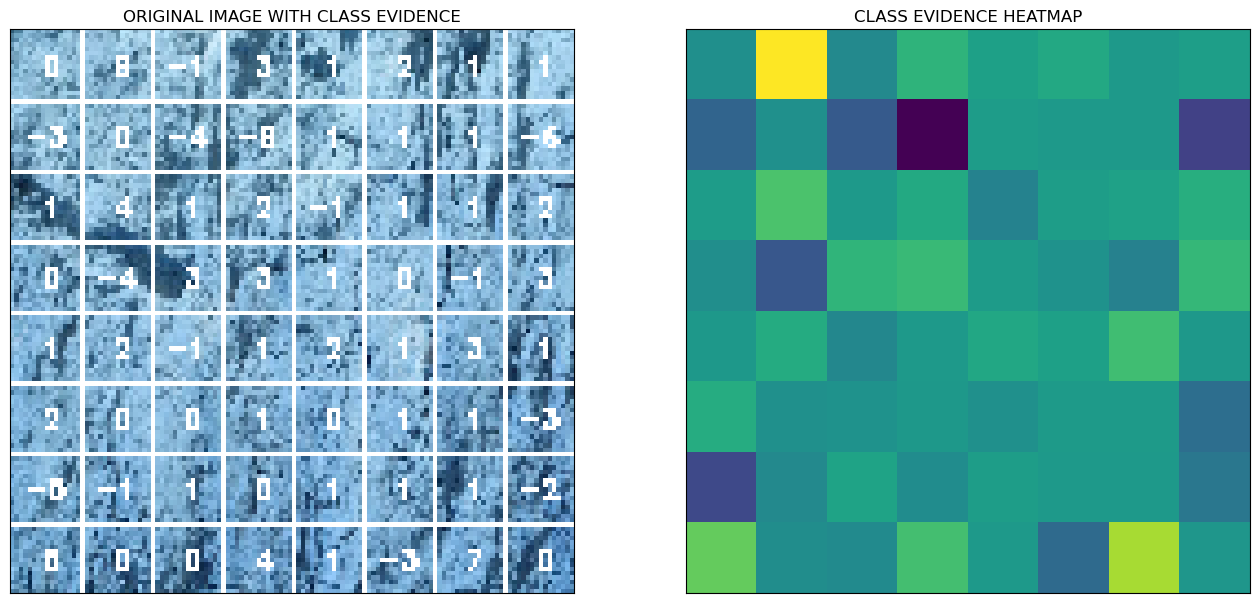

In [50]:
ratesColor = (100,100,100)
displayPredictionResults( model, x_test, y_test, 2, ratesColor, 8 )

IMAGE => 25
1/1 [==============================] - 8s 8s/step


C:\Users\vivek\AppData\Local\Temp\ipykernel_31512\4092623408.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.imshow(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference:  clay=> 0.1999955    loam=> 0.20001127    loamysand=> 0.19999735    sand=> 0.19999546    sandyloam=> 0.20000039


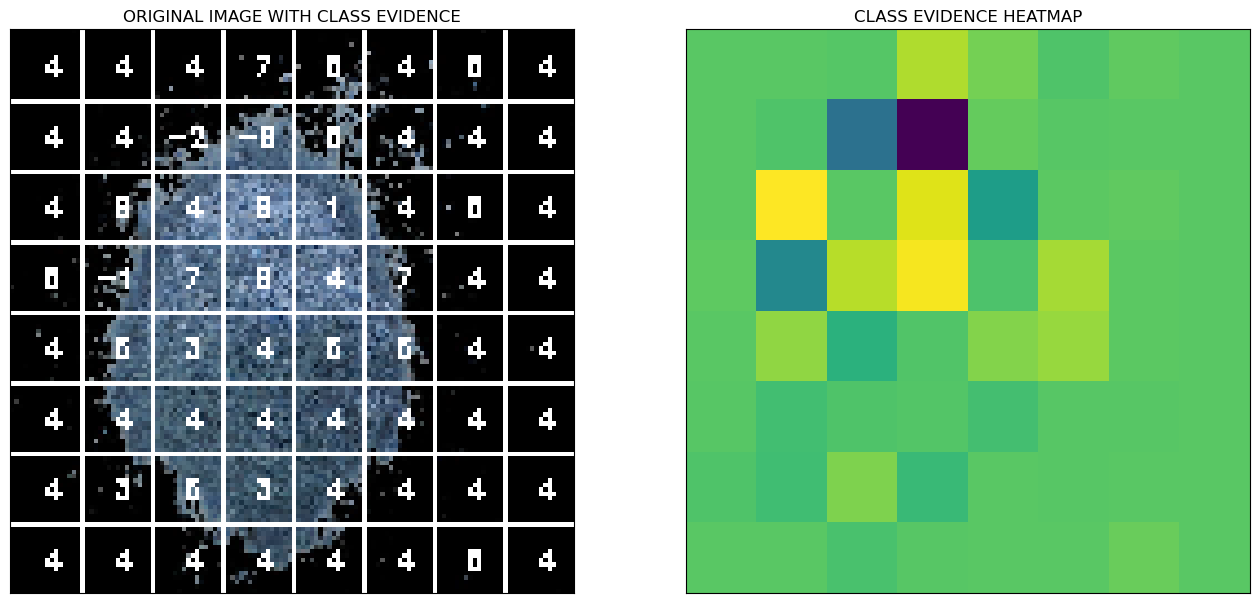

In [53]:
displayPredictionResults( model, x_test, y_test, 25, ratesColor, 8 )

IMAGE => 36
1/1 [==============================] - 9s 9s/step


C:\Users\vivek\AppData\Local\Temp\ipykernel_31512\4092623408.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.imshow(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference:  clay=> 0.1999892    loam=> 0.20001622    loamysand=> 0.19999939    sand=> 0.1999921    sandyloam=> 0.20000307


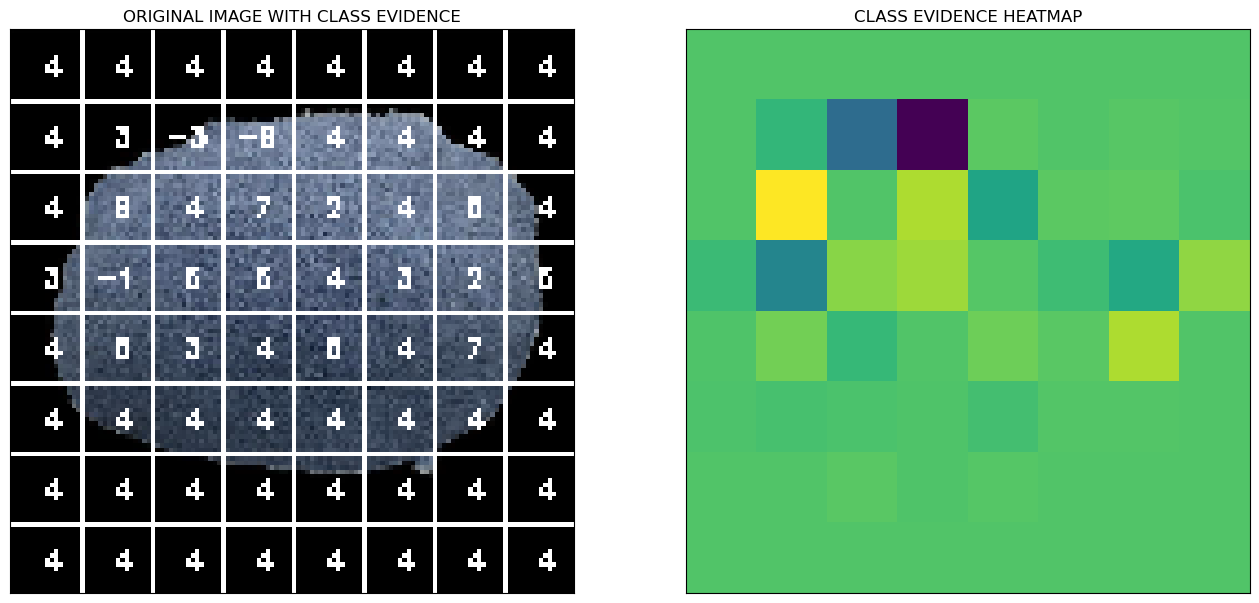

In [54]:
displayPredictionResults( model, x_test, y_test, 36, ratesColor, 8 )

IMAGE => 42
1/1 [==============================] - 8s 8s/step


C:\Users\vivek\AppData\Local\Temp\ipykernel_31512\4092623408.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.imshow(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference:  clay=> 0.20000121    loam=> 0.19999884    loamysand=> 0.20000818    sand=> 0.19999483    sandyloam=> 0.1999969


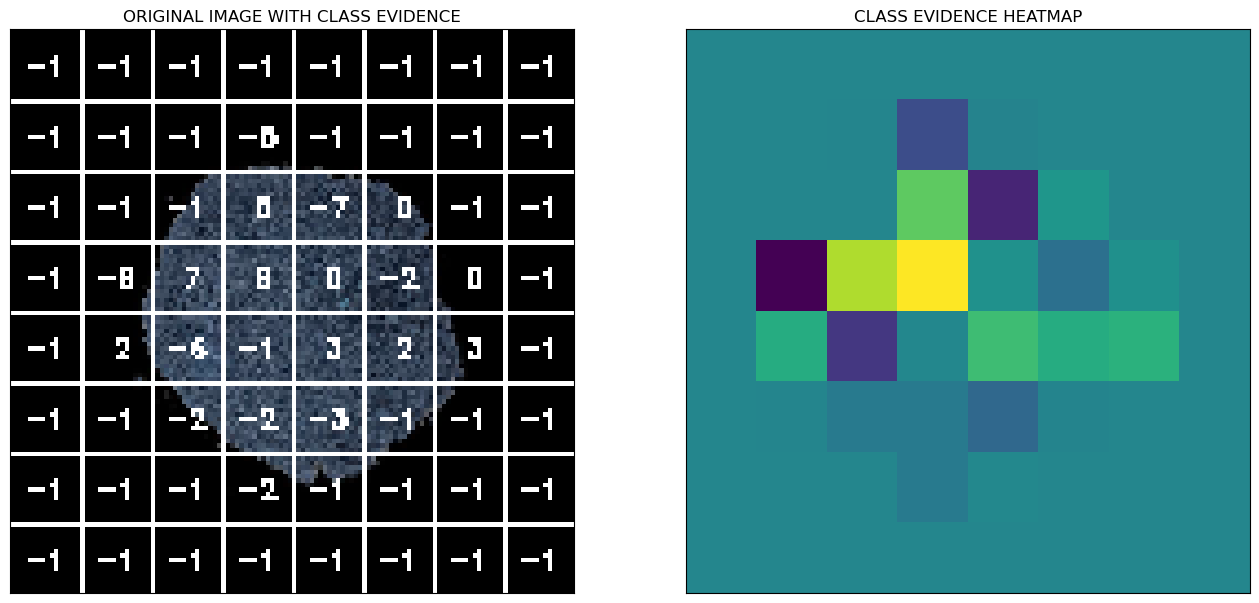

In [55]:
displayPredictionResults( model, x_test, y_test, 42, ratesColor, 8 )

IMAGE => 109
1/1 [==============================] - 9s 9s/step


C:\Users\vivek\AppData\Local\Temp\ipykernel_31512\4092623408.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1), plt.imshow(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Inference:  clay=> 0.2000035    loam=> 0.20000006    loamysand=> 0.20001625    sand=> 0.19999327    sandyloam=> 0.19998683


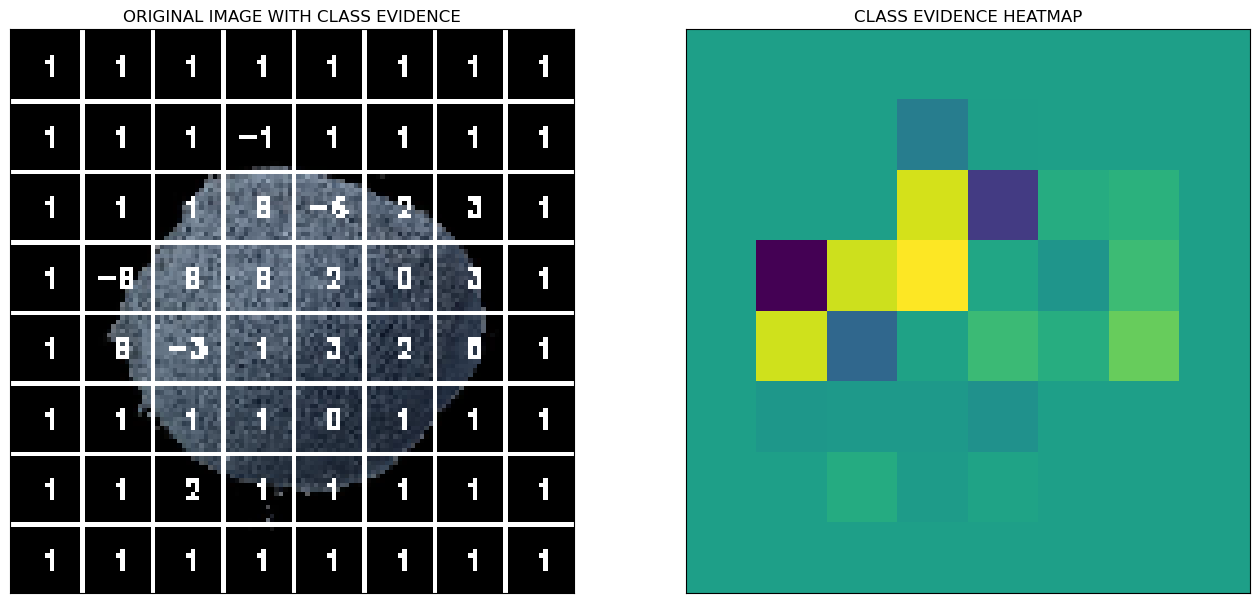

In [56]:
displayPredictionResults( model, x_test, y_test, 109, ratesColor, 8 )

In [57]:
model.predict(x_test)

4/4 [==============================] - 0s 46ms/step


array([[0.19271077, 0.19744247, 0.20366108, 0.20348778, 0.20269787],
       [0.19453923, 0.1972158 , 0.20245802, 0.20135194, 0.204435  ],
       [0.19326842, 0.19713043, 0.2015731 , 0.20255779, 0.20547026],
       [0.19499968, 0.19836773, 0.20078076, 0.20038453, 0.20546733],
       [0.19448175, 0.1978004 , 0.20251943, 0.20093524, 0.20426317],
       [0.19387011, 0.19698977, 0.20237935, 0.20211491, 0.20464592],
       [0.19595936, 0.19796489, 0.20008323, 0.20172136, 0.20427112],
       [0.19605576, 0.19872066, 0.20119068, 0.20039997, 0.203633  ],
       [0.19609365, 0.19743375, 0.20050634, 0.20219898, 0.20376731],
       [0.1947539 , 0.1970022 , 0.20347193, 0.20093553, 0.2038364 ],
       [0.19324064, 0.19623417, 0.20315889, 0.2042277 , 0.20313859],
       [0.19449584, 0.19741885, 0.2035    , 0.20352347, 0.20106189],
       [0.19500248, 0.19708969, 0.20138858, 0.20405038, 0.20246886],
       [0.19312823, 0.19729896, 0.2026136 , 0.20264378, 0.20431541],
       [0.19551487, 0.19497424, 0.